In [1]:
import csv
import pandas as pd
import scipy
import scipy.io
import scipy.integrate
import scipy.signal
from scipy.signal import argrelextrema
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math
#from numpy.fft import fft
import numpy.fft as fft

In [2]:
Re = 102500
n_modes = 20
plt.set_cmap("bwr")

mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\github_repo\A10PIVuv.mat')
data = list(mat.items())

u = data[7]
u_mean = data[9]
v = data[8]
v_mean = data[10]
x = data[11]
y = data[12]
ts = data[3][1][0][0] # time step between snapshots
print(np.shape(u), u[0], np.shape(u_mean), u_mean[0], np.shape(v), v[0], np.shape(v_mean), v_mean[0])

samples = len(u[1])             # number of snapshots in input data
h = len(u[1][1][1])             # height of matrix = y
l = len(u[1][1])                # length of matrix = x
h_trunc = 35                    # y truncation for input data
l_trunc = 150                   # x truncation for input data
t_trunc = samples #samples                 # number of time snapshots for SVD

print(samples, h, l)

(2,) u (2,) u_mean (2,) v (2,) v_mean
3499 66 186


D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


<Figure size 432x288 with 0 Axes>

In [3]:
xs = []
for i in range(0, l_trunc):
    #xs.append(x[1][i][1])
    #xs.append(x[1][i][1])
    xs.append(i)
    
ys = []
for i in range(0,h_trunc*2):
    ys.append(i)
#ys = y[1][1][0:(h_trunc)]

(3499, 70, 150)


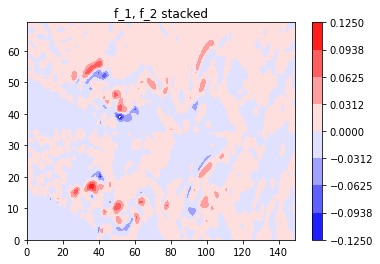

In [4]:
F = np.empty([t_trunc,h_trunc*2,l_trunc])
U = np.empty([t_trunc,h_trunc*2,l_trunc])
u_1 = []
u_2 = []
print(np.shape(F))
for i in range(0,t_trunc):
    u1 = np.rot90(u[1][i],3) # U dataset already has mean subtracted
    u1 = np.delete(u1, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    u1 = np.delete(u1, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    u_1.append(u1)
    
    u2 = np.rot90(v[1][i]-v_mean[1][0],3) # V dataset requires mean to be subtracted
    u2 = np.delete(u2, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    u2 = np.delete(u2, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    u_2.append(u2)
    
    du1_dx2,du1_dx1 = np.negative(np.gradient(u1)) # X gradients in y, x (check order in future)
    du2_dx2,du2_dx1 = np.negative(np.gradient(u2)) # Y gradients in y, x
    
    
    f_1 = np.multiply(u1, du1_dx1) + np.multiply(u2, du1_dx2) # U dataset
    f_2 = np.multiply(u1, du2_dx1) + np.multiply(u2, du2_dx2) # V dataset
    
    F[i,:,:] = np.append(f_1, f_2, axis=0)
    U[i,:,:] = np.append(u1, u2, axis=0)
    
fig, ax = plt.subplots()
levels = np.linspace(-0.125, 0.125, 9)
cs = ax.contourf(F[0], levels=levels)
ax.set_title('f_1, f_2 stacked')
fig.colorbar(cs, ax=ax)
plt.plot()
fig.canvas.draw()

In [5]:
# Transpose such that snapshots are 3rd dimension of matrix
F_transpose = np.transpose(F)
U_transpose = np.transpose(U)
print(np.shape(F_transpose))

# Transpose back to snapshots as 1st dimension for indexing
u_omega = np.transpose(fft.fft(U_transpose))
f_omega = np.transpose(fft.fft(F_transpose))
print(np.shape(u_omega))

max_omega = np.zeros(t_trunc)
max_omega_f = np.zeros(t_trunc)
for i in range(0, t_trunc):
    max_omega[i] = u_omega[i].real.max()
    max_omega_f[i] = f_omega[i].real.max()

(150, 70, 3499)
(3499, 70, 150)


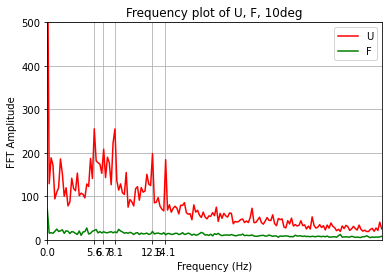

In [9]:
N = t_trunc
n = np.arange(N/2)

sr = 1/ts # sampling rate, Hz
t = np.arange(0,N/sr,ts)
# Get the one-sided specturm
n_oneside = int(N/2)+1
# get the one side frequency
f_oneside = n*2*np.pi*sr/(2*n_oneside)

xmax = 40 #sr

fig, ax = plt.subplots()
ax.set_xticks([0,5.6,6.7,8.1,12.5,14.1])
ax.plot(f_oneside,max_omega[:n_oneside], 'r')
ax.plot(f_oneside,max_omega_f[:n_oneside], 'g')
ax.set_xlim(0, xmax)
ax.set_ylim(0, 500)
ax.set(xlabel='Frequency (Hz)', ylabel='FFT Amplitude',
       title='Frequency plot of U, F, 10deg')
ax.legend(['U','F'])
ax.grid()
plt.show()
# A lot of the structure in A10 is down to the velocity field, not the nonlinear forcing
# Yet we still get coherent nonlinear transfer maps when computing from nonlinear forcing and velocity field

D:\Anaconda3\lib\site-packages\numpy\ma\core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


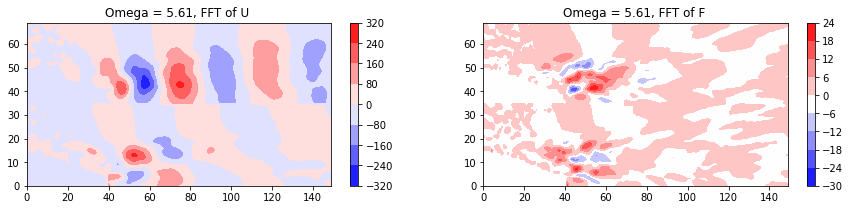

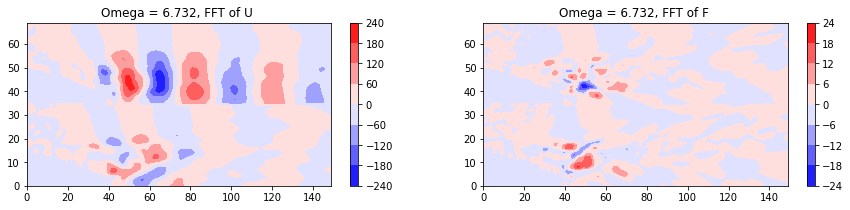

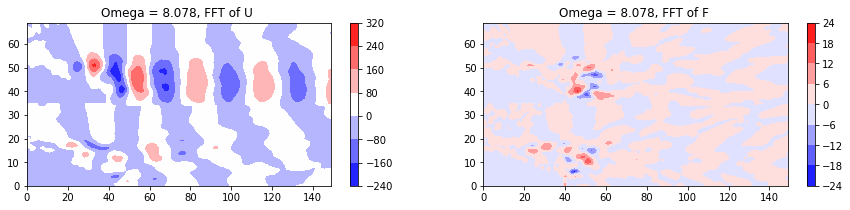

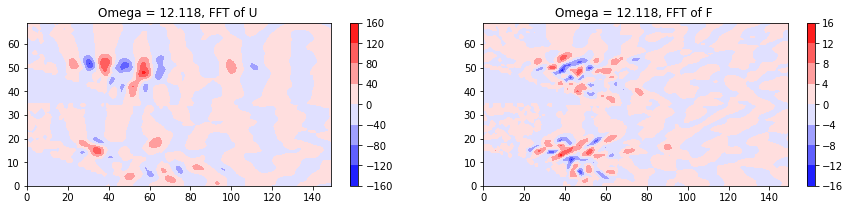

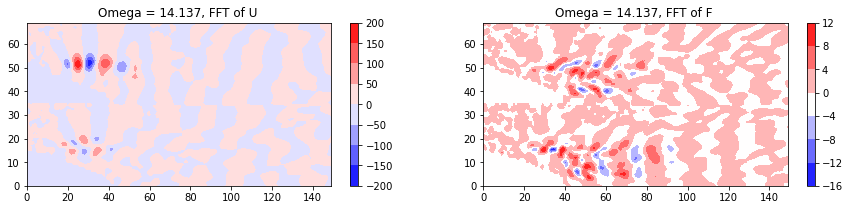

In [14]:
Frequencies = [25,30,36,54,63]

for i in Frequencies:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
    cs1 = ax1.contourf(u_omega[i])
    ax1.set_title('Omega = ' + str(round(f_oneside[i],3)) + ', FFT of U ')
    fig.colorbar(cs1, ax=ax1)
    cs2 = ax2.contourf(f_omega[i])
    ax2.set_title('Omega = ' + str(round(f_oneside[i],3)) + ', FFT of F ')
    fig.colorbar(cs2, ax=ax2)
    plt.plot()
    fig.canvas.draw()

In [10]:
f_dmd_1 = []
f_dmd_2 = []

f_dmd_imag = []
f_dmd_real = []

for i in range(0, len(u_omega)):
    # split U and V components for each real and imaginary part of each mode
    f_dmd_imag.append(np.vsplit(f_omega[i].imag,2))
    f_dmd_real.append(np.vsplit(f_omega[i].real,2))
    
    f_dmd_1.append(np.vectorize(complex)(f_dmd_real[i][1], f_dmd_imag[i][1])) # [1] index represents U component
    f_dmd_2.append(np.vectorize(complex)(f_dmd_real[i][0], f_dmd_imag[i][0])) # [0] index represents V component
    
V_dmd_1 = []
V_dmd_2 = []

V_dmd_imag = []
V_dmd_real = []

for i in range(0, len(u_omega)):
    # split U and V components for each real and imaginary part of each mode
    V_dmd_imag.append(np.vsplit(u_omega[i].imag,2))
    V_dmd_real.append(np.vsplit(u_omega[i].real,2))
    
    V_dmd_1.append(np.vectorize(complex)(V_dmd_real[i][1], V_dmd_imag[i][1])) # [1] index represents U component
    V_dmd_2.append(np.vectorize(complex)(V_dmd_real[i][0], V_dmd_imag[i][0])) # [0] index represents V component

print(np.shape(f_dmd_imag))
print(np.shape(f_dmd_1))

(3499, 2, 35, 150)
(3499, 35, 150)


In [11]:
Nonlinear = []
N_max = []
for i in range(0, len(u_omega)):
    
    Nonlinear.append((
            np.multiply(np.transpose(np.matrix(V_dmd_1[i]).getH()),f_dmd_1[i]) +
            np.multiply(V_dmd_1[i],np.transpose(np.matrix(f_dmd_1[i]).getH())) +
            np.multiply(np.transpose(np.matrix(V_dmd_2[i]).getH()),f_dmd_2[i]) +
            np.multiply(V_dmd_2[i],np.transpose(np.matrix(f_dmd_2[i]).getH()))
        ))
    # Find largest value in plot to define scale later
    N_max.append(max(Nonlinear[i].max(),-Nonlinear[i].min()))
print(np.shape(Nonlinear), np.shape(N_max))

(3499, 35, 150) (3499,)


[]

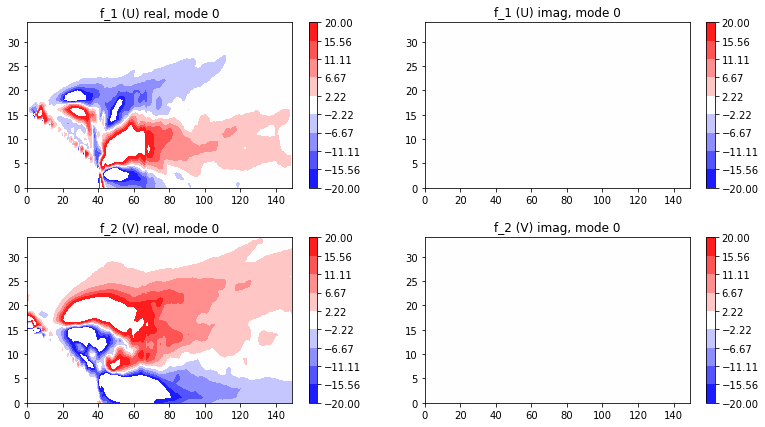

In [12]:
i = 0    # Mode number we are plotting
term = [f_dmd_real[i][0], f_dmd_imag[i][0], f_dmd_real[i][1], f_dmd_imag[i][1]]
term_name = ["f_1 (U) real, mode "+str(i), "f_1 (U) imag, mode "+str(i),
             "f_2 (V) real, mode "+str(i), "f_2 (V) imag, mode "+str(i)]
n = 0
fig, axes = plt.subplots(2, 2, figsize = (15,7))
for ax in axes.flat:
    levels = np.linspace(-20, 20, 10)
    cs = ax.contourf(term[n], levels = levels)
    ax.set_title(term_name[n])
    fig.colorbar(cs, ax=ax)
    n = n+1

fig.subplots_adjust(hspace = 0.3)
fig.subplots_adjust(right=0.8)
plt.plot()

D:\Anaconda3\lib\site-packages\numpy\ma\core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
D:\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


[]

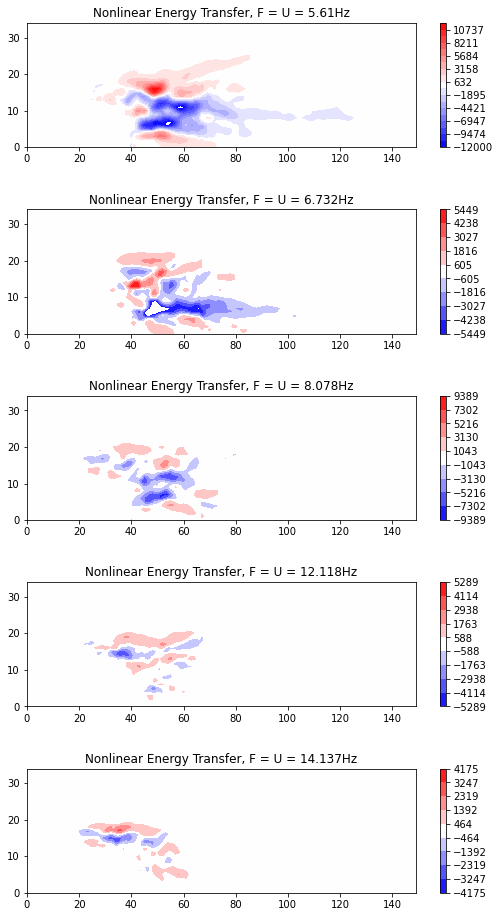

In [31]:
fig, axes = plt.subplots(len(Frequencies), 1, figsize = (10,16))
n = 0
for ax in axes.flat:
    levels = np.linspace(-N_max[n], N_max[n], 10) # Scale plot levels
    if n==0:
        levels = np.linspace(-12000, 12000, 20)
    cs = ax.contourf(Nonlinear[Frequencies[n]], levels = levels)
    ax.set_title('Nonlinear Energy Transfer, F = U = ' + str(round(f_oneside[Frequencies[n]],3)) + 'Hz')
    fig.colorbar(cs, ax=ax)
    n = n+1
    
fig.subplots_adjust(hspace = 0.5)
fig.subplots_adjust(right=0.8)

plt.plot()

# Fixed the order of U and V components in f after DMD to give correct figures.

In [30]:
imag = []
real = []
freq = []
for i in Frequencies:
    imag.append(np.reshape(u_omega[i].imag,(h_trunc*2*l_trunc)))
    real.append(np.reshape(u_omega[i].real,(h_trunc*2*l_trunc)))
    freq.append(round(f_oneside[i],3))

print(np.shape(imag))

import csv
filename = "dmd_10_F.csv"
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(imag)
    csvwriter.writerows(real)
    
np.savetxt('dmd_F_10_freqs.csv', freq, delimiter = ',')

(5, 10500)


[-1050330.961746843, -591085.225446573, -541359.055221604, -61525.12053794081, 59418.56074800315]


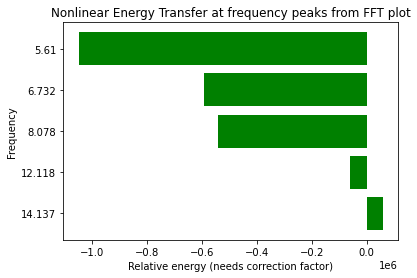

In [32]:
N_sum = []
for i in range(0,len(Frequencies)):
    N_sum.append(Nonlinear[Frequencies[i]].real.sum())
print(N_sum)

ind = []
for i in range(0,len(Frequencies)):
    ind.append(str(round(f_oneside[Frequencies[i]],3)))

x=range(len(Frequencies))

plt.figure()
plt.ylabel('Frequency')
plt.xlabel('Relative energy (needs correction factor)')
plt.title('Nonlinear Energy Transfer at frequency peaks from FFT plot')
plt.barh(ind,N_sum,color='g')
plt.gca().invert_yaxis()

-1050330.961746843


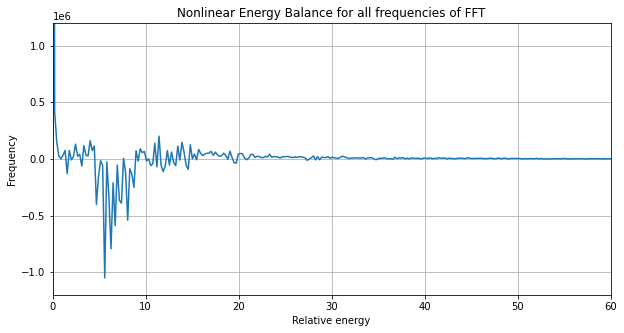

In [29]:
#Plot Nonlinear Energy balance for all frequencies of FFT (line plot)
N_sum = []
for i in range(0, len(f_oneside)):
    N_sum.append(Nonlinear[i].real.sum())
print(N_sum[Frequencies[0]])

plt.figure(figsize=(10,5))
plt.plot(f_oneside, N_sum)
plt.xlim(0,60)
plt.ylim(-1200000,1200000)
plt.title('Nonlinear Energy Balance for all frequencies of FFT')
plt.xlabel('Relative energy')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [15]:
#Frequency information

print("Sampling freq: " + str(ts) + "Hz")
print("Frequency bin size: " + str(round(f_oneside[1],3)) + "Hz")

Sampling freq: 0.008Hz
Frequency bin size: 0.224Hz
